In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import argparse

import torch

import esm
import sys
sys.path.insert(0, "../")
import esm_adapterH

import numpy as np
import yaml
from utils.utils import load_configs
from collections import OrderedDict
from Bio.PDB import PDBParser, PPBuilder
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import pairwise_distances
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from peft import PeftModel, LoraConfig, get_peft_model


# def load_checkpoints(model,checkpoint_path):
#         if checkpoint_path is not None:
#             checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
#             if np.sum(["adapter_layer_dict" in key for key in checkpoint[
#                 'state_dict1'].keys()]) == 0:  # using old checkpoints, need to rename the adapter_layer into adapter_layer_dict.adapter_0
#                 new_ordered_dict = OrderedDict()
#                 for key, value in checkpoint['state_dict1'].items():
#                     if "adapter_layer_dict" not in key:
#                         new_key = key.replace('adapter_layer', 'adapter_layer_dict.adapter_0')
#                         new_ordered_dict[new_key] = value
#                     else:
#                         new_ordered_dict[key] = value
                
#                 model.load_state_dict(new_ordered_dict, strict=False)
#             else:
#                 #this model does not contain esm2
#                 new_ordered_dict = OrderedDict()
#                 for key, value in checkpoint['state_dict1'].items():
#                         key = key.replace("esm2.","")
#                         new_ordered_dict[key] = value
                
#                 model.load_state_dict(new_ordered_dict, strict=False)
            
#             print("checkpoints were loaded from " + checkpoint_path)
#         else:
#             print("checkpoints not exist "+ checkpoint_path)

def load_checkpoints(model,checkpoint_path):
        if checkpoint_path is not None:
            checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
            if  any('adapter' in name for name, _ in model.named_modules()):
                if np.sum(["adapter_layer_dict" in key for key in checkpoint[
                    'state_dict1'].keys()]) == 0:  # using old checkpoints, need to rename the adapter_layer into adapter_layer_dict.adapter_0
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                        if "adapter_layer_dict" not in key:
                            new_key = key.replace('adapter_layer', 'adapter_layer_dict.adapter_0')
                            new_ordered_dict[new_key] = value
                        else:
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
                else:
                    #this model does not contain esm2
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                            key = key.replace("esm2.","")
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
            elif  any('lora' in name for name, _ in model.named_modules()):
                #this model does not contain esm2
                new_ordered_dict = OrderedDict()
                for key, value in checkpoint['state_dict1'].items():
                        print(key)
                        key = key.replace("esm2.","")
                        new_ordered_dict[key] = value
                
                model.load_state_dict(new_ordered_dict, strict=False)
            
            print("checkpoints were loaded from " + checkpoint_path)
        else:
            print("checkpoints not exist "+ checkpoint_path)

# def load_model(args):
#     if args.model_type=="d-plm":
#         with open(args.config_path) as file:
#             config_file = yaml.full_load(file)
#             configs = load_configs(config_file, args=None)
        
#         # inference for each model
#         model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)
#         load_checkpoints(model,args.model_location)
#     elif args.model_type=="ESM2":
#         #if use ESM2
#         model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    
    
#     model.eval()
#     if torch.cuda.is_available():
#         model = model.cuda()
#         print("Transferred model to GPU")
    
#     return model,alphabet

def load_model(args):
    if args.model_type=="d-plm":
        with open(args.config_path) as file:
            config_file = yaml.full_load(file)
            configs = load_configs(config_file, args=None)
        if configs.model.esm_encoder.adapter_h.enable:
            model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)
        elif configs.model.esm_encoder.lora.enable:
            model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
            lora_targets =  ["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj","self_attn.out_proj"]
            target_modules=[]
            if configs.model.esm_encoder.lora.esm_num_end_lora > 0:
                start_layer_idx = np.max([model.num_layers - configs.model.esm_encoder.lora.esm_num_end_lora, 0])
                for idx in range(start_layer_idx, model.num_layers):
                    for layer_name in lora_targets:
                        target_modules.append(f"layers.{idx}.{layer_name}")
                
            peft_config = LoraConfig(
                inference_mode=False,
                r=configs.model.esm_encoder.lora.r,
                lora_alpha=configs.model.esm_encoder.lora.alpha,
                target_modules=target_modules,
                lora_dropout=configs.model.esm_encoder.lora.dropout,
                bias="none",
                # modules_to_save=modules_to_save
            )
            peft_model = get_peft_model(model, peft_config)
        
        # inference for each model
        # model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)/
        load_checkpoints(model,args.model_location)
    elif args.model_type=="ESM2":
        #if use ESM2
        model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    
    
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")
    
    return model,alphabet

def main(args):
    batch_converter = args.alphabet.get_batch_converter()
    
    data = [
        ("protein1", args.sequence),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    
    with torch.no_grad():
        wt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    
    wt_representation = wt_representation.squeeze(0) #only one sequence a time
    return wt_representation

c:\Users\yjm85\Anaconda3\envs\dplm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='../results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='../results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='d-plm', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()



In [25]:
args


Namespace(model_location='../results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth', config_path='../results/vivit_3/config_vivit3.yaml', model_type='d-plm', sequence=None, output_path='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/')

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ── 1. Load & parse data ──────────────────────────────────────────────────────
df_raw = pd.read_excel('/evaluate/phase_sep/tableS1.xlsx', header=None)
records = []
current_class = None
current_id = None
for _, row in df_raw.iterrows():
    if pd.notna(row[0]):
        current_class = row[0]
    if pd.notna(row[1]):
        val = str(row[1])
        if val.startswith('>'):
            current_id = val.split()[0][1:]
        else:
            records.append({'class': current_class, 'id': current_id, 'sequence': val})
data = pd.DataFrame(records)

labels = (data['class'] == 'Positive').astype(int).values  # 0=Neg, 1=Pos
label_names = data['class'].values
sequences = data['sequence'].values

# ── 2. Embedding Method 1: k-mer frequencies (k=3) ───────────────────────────
# def kmer_features(seq, k=3):
#     seq = seq.upper()
#     kmers = [seq[i:i+k] for i in range(len(seq)-k+1)]
#     total = len(kmers)
#     counts = Counter(kmers)
#     # Use top 200 most common 3-mers from the corpus
#     return counts, total

# # Build vocabulary
# all_counts = []
# for seq in sequences:
#     c, _ = kmer_features(seq)
#     all_counts.append(c)

# vocab = Counter()
# for c in all_counts:
#     vocab.update(c.keys())
# top_kmers = [k for k, _ in vocab.most_common(200)]

# def vectorize_kmer(seq, vocab):
#     c, total = kmer_features(seq)
#     return np.array([c.get(k, 0) / max(total, 1) for k in vocab])

# X_kmer = np.vstack([vectorize_kmer(s, top_kmers) for s in sequences])

# # ── 3. Embedding Method 2: Physicochemical properties ────────────────────────
# # Amino acid physicochemical property vectors
# PROPS = {
#     'A': [1.8, 0, 0, 89, 0], 'R': [-4.5, 1, 1, 174, 0],
#     'N': [-3.5, 0, 0, 132, 0], 'D': [-3.5, -1, 0, 133, 0],
#     'C': [2.5, 0, 0, 121, 0], 'Q': [-3.5, 0, 0, 146, 0],
#     'E': [-3.5, -1, 0, 147, 0], 'G': [-0.4, 0, 0, 75, 0],
#     'H': [-3.2, 1, 0, 155, 0], 'I': [4.5, 0, 0, 131, 0],
#     'L': [3.8, 0, 0, 131, 0], 'K': [-3.9, 1, 0, 146, 0],
#     'M': [1.9, 0, 0, 149, 0], 'F': [2.8, 0, 0, 165, 0],
#     'P': [-1.6, 0, 0, 115, 0], 'S': [-0.8, 0, 0, 105, 0],
#     'T': [-0.7, 0, 0, 119, 0], 'W': [-0.9, 0, 0, 204, 1],
#     'Y': [-1.3, 0, 0, 181, 0], 'V': [4.2, 0, 0, 117, 0],
# }
# default_prop = [0, 0, 0, 110, 0]

# def physico_features(seq):
#     seq = seq.upper()
#     props = np.array([PROPS.get(aa, default_prop) for aa in seq if aa in 'ACDEFGHIKLMNPQRSTVWY'])
#     if len(props) == 0:
#         return np.zeros(15)
#     mean_p = props.mean(axis=0)
#     std_p = props.std(axis=0)
#     max_p = props.max(axis=0)
#     return np.concatenate([mean_p, std_p, max_p])

# X_phys = np.vstack([physico_features(s) for s in sequences])

# ── 3. Embedding Method 3: dplm ────────────────────────

parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='../results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='../results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='d-plm', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

args.model,args.alphabet = load_model(args)

dplm_emb=[]
ind=0
for seq in sequences:
    print(ind)
    ind+=1
    args.sequence = seq
    wt_output = main(args)
    emb = wt_output[1:-1].cpu().numpy()
    dplm_emb.append(np.mean(emb, axis=0))

dplm_emb=np.vstack(dplm_emb)

# ── 3. Embedding Method 4: esm ────────────────────────
parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='ESM2', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

args.model,args.alphabet = load_model(args)

esm2_emb=[]
ind=0
for seq in sequences:
    print(ind)
    ind+=1
    args.sequence = seq
    wt_output = main(args)
    emb = wt_output[1:-1].cpu().numpy()
    esm2_emb.append(np.mean(emb, axis=0))

esm2_emb=np.vstack(esm2_emb)
# ── 3. Embedding Method 5: seqdance ────────────────────────
from transformers import AutoTokenizer
if not "C:\\Users\yjm85\\Downloads\\SeqDance-main\\SeqDance-main\\model" in sys.path:
  sys.path.insert(0, "C:\\Users\yjm85\\Downloads\\SeqDance-main\\SeqDance-main\\model")
from model import ESMwrap
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
esm2_select = 'model_35M'
model_select = 'seqdance' # 'seqdance' or 'esmdance'
dance_model = ESMwrap(esm2_select, model_select)
# Load the SeqDance model from huggingface
dance_model = dance_model.from_pretrained("ChaoHou/ESMDance")
dance_model = dance_model.to(device)
dance_model.eval()

seqdance_emb=[]
new_label_names=[]
new_labels = []
ind=0
for seq in sequences:
    if len(seq)>1024:
        continue
    new_label_names.append(label_names[ind])
    new_labels.append(labels[ind])
    print(ind)
    ind+=1
    raw_input = tokenizer([seq], return_tensors="pt")
    raw_input = raw_input.to(device)
    with torch.no_grad():
        seq_emb = dance_model(raw_input, return_res_emb=True, return_attention_map=False, return_res_pred=False, return_pair_pred=False)
        seq_emb = seq_emb['res_emb'][:,1:-1,:].squeeze(0)
        emb = seq_emb.cpu().numpy()
        seqdance_emb.append(np.mean(emb, axis=0))

seqdance_emb=np.vstack(seqdance_emb)
new_label_names=np.array(new_label_names)
# ── 4. Reduce to 2D with t-SNE ────────────────────────────────────────────────
# scaler = StandardScaler()

# X_kmer_scaled = scaler.fit_transform(X_kmer)
# pca_kmer = PCA(n_components=50, random_state=42)
# X_kmer_pca = pca_kmer.fit_transform(X_kmer_scaled)
# tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
# emb1 = tsne1.fit_transform(X_kmer_pca)

# X_phys_scaled = scaler.fit_transform(X_phys)
# tsne2 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
# emb2 = tsne2.fit_transform(X_phys_scaled)

# ── 5. K-means clustering (k=2) & ARI ─────────────────────────────────────────
# km1 = KMeans(n_clusters=2, random_state=42, n_init=10)
# cluster1 = km1.fit_predict(X_kmer_scaled)
# ari1 = adjusted_rand_score(labels, cluster1)

# km2 = KMeans(n_clusters=2, random_state=42, n_init=10)
# cluster2 = km2.fit_predict(X_phys_scaled)
# ari2 = adjusted_rand_score(labels, cluster2)

# print(f"ARI — k-mer (Method 1):         {ari1:.4f}")
# print(f"ARI — Physicochemical (Method 2): {ari2:.4f}")

# ── 4. Reduce dplm emb to 2D with t-SNE ────────────────────────────────────────────────
scaler = StandardScaler()

dplm_emb_scaled = scaler.fit_transform(dplm_emb)
pca_dplm = PCA(n_components=50, random_state=42)
dplm_emb_pca = pca_dplm.fit_transform(dplm_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb1 = tsne1.fit_transform(dplm_emb_pca)

# ── 4. Reduce ESM2 emb to 2D with t-SNE ────────────────────────────────────────────────
scaler = StandardScaler()

esm2_emb_scaled = scaler.fit_transform(esm2_emb)
pca_esm2 = PCA(n_components=50, random_state=42)
esm2_emb_pca = pca_esm2.fit_transform(esm2_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb2 = tsne1.fit_transform(esm2_emb_pca)

# ── 4. Reduce seqdance emb to 2D with t-SNE ────────────────────────────────────────────────
scaler = StandardScaler()

seqdance_emb_scaled = scaler.fit_transform(seqdance_emb)
pca_seqdance = PCA(n_components=50, random_state=42)
seqdance_emb_pca = pca_seqdance.fit_transform(seqdance_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb3 = tsne1.fit_transform(seqdance_emb_pca)
# ── 5. K-means clustering (k=2) & ARI ─────────────────────────────────────────
km1 = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster1 = km1.fit_predict(dplm_emb_scaled)
ari1 = adjusted_rand_score(labels, cluster1)

km2 = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster2 = km2.fit_predict(esm2_emb_scaled)
ari2 = adjusted_rand_score(labels, cluster2)

km3 = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster3 = km3.fit_predict(seqdance_emb_scaled)
ari3 = adjusted_rand_score(new_labels, cluster3)

print(f"ARI — k-mer (Method 1):         {ari1:.4f}")
print(f"ARI — Physicochemical (Method 2): {ari2:.4f}")
# ── 6. Plot ───────────────────────────────────────────────────────────────────
COLORS = {'Negative': '#4C72B0', 'Positive': '#DD8452'}
CLUSTER_COLORS = ['#2ca02c', '#d62728']

fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('#F8F9FA')

gs = gridspec.GridSpec(2, 3, hspace=0.38, wspace=0.32,
                       left=0.07, right=0.97, top=0.90, bottom=0.08)

def scatter(ax, emb, color_vals, title, subtitle, legend_labels, palette):
    unique = list(dict.fromkeys(color_vals))
    for val in unique:
        mask = np.array(color_vals) == val
        ax.scatter(emb[mask, 0], emb[mask, 1],
                   c=palette[val] if isinstance(palette, dict) else palette[val],
                   label=legend_labels[val] if isinstance(legend_labels, dict) else legend_labels[val],
                   alpha=0.75, s=40, edgecolors='white', linewidths=0.4)
    ax.set_title(f'{title}\n', fontsize=13, fontweight='bold', color='#2d2d2d')
    ax.text(0.5, 1.01, subtitle, transform=ax.transAxes, ha='center',
            fontsize=10, color='#666666')
    ax.set_xlabel('t-SNE 1', fontsize=10)
    ax.set_ylabel('t-SNE 2', fontsize=10)
    ax.legend(fontsize=9, framealpha=0.85)
    ax.set_facecolor('#FFFFFF')
    for spine in ax.spines.values():
        spine.set_edgecolor('#CCCCCC')
    ax.tick_params(labelsize=8)

# Row 1: true labels
ax1 = fig.add_subplot(gs[0, 0])
label_map = {'Negative': 'Negative', 'Positive': 'Positive'}
scatter(ax1, emb1, label_names, 'Method 1 — k-mer Frequencies (k=3)',
        'True class labels', label_map, COLORS)

ax2 = fig.add_subplot(gs[0, 1])
scatter(ax2, emb2, label_names, 'Method 2 — Physicochemical Properties',
        'True class labels', label_map, COLORS)

ax2 = fig.add_subplot(gs[0, 2])
scatter(ax2, emb3, new_label_names, 'Method 2 — Physicochemical Properties',
        'True class labels', label_map, COLORS)

# Row 2: k-means clusters
cluster_label_map1 = {0: 'Cluster 0', 1: 'Cluster 1'}
cluster_palette = {0: CLUSTER_COLORS[0], 1: CLUSTER_COLORS[1]}

ax3 = fig.add_subplot(gs[1, 0])
scatter(ax3, emb1, cluster1, 'Method 1 — k-mer Frequencies (k=3)',
        f'K-means clusters  |  ARI = {ari1:.3f}',
        cluster_label_map1, cluster_palette)

ax4 = fig.add_subplot(gs[1, 1])
scatter(ax4, emb2, cluster2, 'Method 2 — Physicochemical Properties',
        f'K-means clusters  |  ARI = {ari2:.3f}',
        cluster_label_map1, cluster_palette)

ax4 = fig.add_subplot(gs[1, 2])
scatter(ax4, emb3, cluster3, 'Method 2 — Physicochemical Properties',
        f'K-means clusters  |  ARI = {ari3:.3f}',
        cluster_label_map1, cluster_palette)
# Super title
fig.suptitle('Protein Sequence Embedding Comparison\nt-SNE Visualization & Adjusted Rand Index (ARI)',
             fontsize=15, fontweight='bold', color='#1a1a1a', y=0.97)

plt.savefig('/mnt/user-data/outputs/embedding_comparison.png', dpi=150, bbox_inches='tight',
            facecolor=fig.get_facecolor())
print("Saved to /mnt/user-data/outputs/embedding_comparison.png")

FileNotFoundError: [Errno 2] No such file or directory: '/evaluate/phase_sep/tableS1.xlsx'

In [29]:
########data set 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ── 1. Load & parse ───────────────────────────────────────────────────────────
df_raw = pd.read_excel('../evaluate/phase_sep/tableS2.xlsx', header=None)
df_raw = df_raw.iloc[1:].reset_index(drop=True)

records = []
for i in range(0, len(df_raw) - 1, 2):
    row_a = df_raw.iloc[i]
    row_b = df_raw.iloc[i + 1]
    records.append({
        'class':    row_a[0],
        'subclass': row_a[1],
        'id':       str(row_a[2]).strip('>'),
        'sequence': str(row_b[2])
    })
data = pd.DataFrame(records)
sequences       = data['sequence'].values
class_labels    = data['class'].values
subclass_labels = data['subclass'].values
combined_labels = [f"{c} / {s}" for c, s in zip(class_labels, subclass_labels)]

le_class = LabelEncoder()
y_class  = le_class.fit_transform(class_labels)

print("Group counts:")
print(data.groupby(['class', 'subclass']).size(), "\n")

# ── 2. k-mer frequencies (k=3) ───────────────────────────────────────────────
# def kmer_counts(seq, k=3):
#     seq = seq.upper()
#     kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
#     return Counter(kmers), len(kmers)

# all_counts = [kmer_counts(s)[0] for s in sequences]
# vocab_counter = Counter()
# for c in all_counts:
#     vocab_counter.update(c.keys())
# top_kmers = [k for k, _ in vocab_counter.most_common(200)]

# def vectorize_kmer(seq):
#     c, total = kmer_counts(seq)
#     return np.array([c.get(k, 0) / max(total, 1) for k in top_kmers])

# X_kmer = np.vstack([vectorize_kmer(s) for s in sequences])

# # ── 3. Physicochemical properties ────────────────────────────────────────────
# PROPS = {
#     'A': [1.8, 0, 0, 89,  0], 'R': [-4.5, 1, 1, 174, 0],
#     'N': [-3.5, 0, 0, 132, 0], 'D': [-3.5,-1, 0, 133, 0],
#     'C': [2.5,  0, 0, 121, 0], 'Q': [-3.5, 0, 0, 146, 0],
#     'E': [-3.5,-1, 0, 147, 0], 'G': [-0.4, 0, 0,  75, 0],
#     'H': [-3.2, 1, 0, 155, 0], 'I': [4.5,  0, 0, 131, 0],
#     'L': [3.8,  0, 0, 131, 0], 'K': [-3.9, 1, 0, 146, 0],
#     'M': [1.9,  0, 0, 149, 0], 'F': [2.8,  0, 0, 165, 0],
#     'P': [-1.6, 0, 0, 115, 0], 'S': [-0.8, 0, 0, 105, 0],
#     'T': [-0.7, 0, 0, 119, 0], 'W': [-0.9, 0, 0, 204, 1],
#     'Y': [-1.3, 0, 0, 181, 0], 'V': [4.2,  0, 0, 117, 0],
# }
# default_prop = [0, 0, 0, 110, 0]

# def physico_features(seq):
#     props = np.array([PROPS.get(aa, default_prop)
#                       for aa in seq.upper() if aa in PROPS])
#     if len(props) == 0:
#         return np.zeros(15)
#     return np.concatenate([props.mean(0), props.std(0), props.max(0)])

# X_phys = np.vstack([physico_features(s) for s in sequences])
# ── 3. Embedding Method 3: dplm ────────────────────────

parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='../results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='../results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='d-plm', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

args.model,args.alphabet = load_model(args)

dplm_emb=[]
ind=0
for seq in sequences:
    print(ind)
    ind+=1
    args.sequence = seq
    wt_output = main(args)
    emb = wt_output[1:-1].cpu().numpy()
    dplm_emb.append(np.mean(emb, axis=0))

dplm_emb=np.vstack(dplm_emb)

# ── 3. Embedding Method 4: esm ────────────────────────
parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='ESM2', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

args.model,args.alphabet = load_model(args)

esm2_emb=[]
ind=0
for seq in sequences:
    print(ind)
    ind+=1
    args.sequence = seq
    wt_output = main(args)
    emb = wt_output[1:-1].cpu().numpy()
    esm2_emb.append(np.mean(emb, axis=0))

esm2_emb=np.vstack(esm2_emb)
# ── 3. Embedding Method 5: seqdance ────────────────────────
from transformers import AutoTokenizer
if not "C:\\Users\yjm85\\Downloads\\SeqDance-main\\SeqDance-main\\model" in sys.path:
  sys.path.insert(0, "C:\\Users\yjm85\\Downloads\\SeqDance-main\\SeqDance-main\\model")
from model import ESMwrap
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
esm2_select = 'model_35M'
model_select = 'seqdance' # 'seqdance' or 'esmdance'
dance_model = ESMwrap(esm2_select, model_select)
# Load the SeqDance model from huggingface
dance_model = dance_model.from_pretrained("ChaoHou/ESMDance")
dance_model = dance_model.to(device)
dance_model.eval()

seqdance_emb=[]
new_label_names=[]
new_y_class=[]
ind=0
for seq in sequences:
    if len(seq)>1024:
        continue
    new_label_names.append(combined_labels[ind])
    new_y_class.append(y_class[ind])
    print(ind)
    ind+=1
    raw_input = tokenizer([seq], return_tensors="pt")
    raw_input = raw_input.to(device)
    with torch.no_grad():
        seq_emb = dance_model(raw_input, return_res_emb=True, return_attention_map=False, return_res_pred=False, return_pair_pred=False)
        seq_emb = seq_emb['res_emb'][:,1:-1,:].squeeze(0)
        emb = seq_emb.cpu().numpy()
        seqdance_emb.append(np.mean(emb, axis=0))

seqdance_emb=np.vstack(seqdance_emb)
new_label_names=np.array(new_label_names)

# ── 4. Scale & t-SNE ─────────────────────────────────────────────────────────
# scaler = StandardScaler()

# X_kmer_sc  = scaler.fit_transform(X_kmer)
# X_kmer_pca = PCA(n_components=50, random_state=42).fit_transform(X_kmer_sc)
# emb1 = TSNE(n_components=2, perplexity=30, random_state=42,
#             max_iter=1000).fit_transform(X_kmer_pca)

# X_phys_sc = scaler.fit_transform(X_phys)
# emb2 = TSNE(n_components=2, perplexity=30, random_state=42,
#             max_iter=1000).fit_transform(X_phys_sc)
# ── 4. Reduce dplm emb to 2D with t-SNE ────────────────────────────────────────────────
scaler = StandardScaler()

dplm_emb_scaled = scaler.fit_transform(dplm_emb)
pca_dplm = PCA(n_components=50, random_state=42)
dplm_emb_pca = pca_dplm.fit_transform(dplm_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb1 = tsne1.fit_transform(dplm_emb_pca)

# ── 4. Reduce ESM2 emb to 2D with t-SNE ────────────────────────────────────────────────
scaler = StandardScaler()

esm2_emb_scaled = scaler.fit_transform(esm2_emb)
pca_esm2 = PCA(n_components=50, random_state=42)
esm2_emb_pca = pca_esm2.fit_transform(esm2_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb2 = tsne1.fit_transform(esm2_emb_pca)

# ── 4. Reduce seqdance emb to 2D with t-SNE ────────────────────────────────────────────────
scaler = StandardScaler()

seqdance_emb_scaled = scaler.fit_transform(seqdance_emb)
pca_seqdance = PCA(n_components=50, random_state=42)
seqdance_emb_pca = pca_seqdance.fit_transform(seqdance_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb3 = tsne1.fit_transform(seqdance_emb_pca)
# ── 5. K-means k=2, ARI vs Negative/Positive ─────────────────────────────────
km1      = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster1 = km1.fit_predict(dplm_emb_scaled)
ari1     = adjusted_rand_score(y_class, cluster1)

km2      = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster2 = km2.fit_predict(esm2_emb_scaled)
ari2     = adjusted_rand_score(y_class, cluster2)

km3      = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster3 = km3.fit_predict(seqdance_emb_scaled)
ari3     = adjusted_rand_score(new_y_class, cluster3)

print(f"ARI — Method 1 (k-mer, k=2 vs Neg/Pos):          {ari1:.4f}")
print(f"ARI — Method 2 (Physicochemical, k=2 vs Neg/Pos): {ari2:.4f}")
print(f"ARI — Method 1 (k-mer, k=2 vs Neg/Pos):          {ari3:.4f}")
# ── 5. K-means k=2, ARI vs Negative/Positive ─────────────────────────────────
# km1      = KMeans(n_clusters=2, random_state=42, n_init=10)
# cluster1 = km1.fit_predict(X_kmer_sc)
# ari1     = adjusted_rand_score(y_class, cluster1)

# km2      = KMeans(n_clusters=2, random_state=42, n_init=10)
# cluster2 = km2.fit_predict(X_phys_sc)
# ari2     = adjusted_rand_score(y_class, cluster2)

# print(f"ARI — Method 1 (k-mer, k=2 vs Neg/Pos):          {ari1:.4f}")
# print(f"ARI — Method 2 (Physicochemical, k=2 vs Neg/Pos): {ari2:.4f}")

# ── 6. Palettes ───────────────────────────────────────────────────────────────
COMBINED_PALETTE = {
    'Negative / Disordered': '#4C72B0',
    'Negative / Folded':     '#55A868',
    'Positive / Disordered': '#DD8452',
    'Positive / Folded':     '#C44E52',
}
CLUSTER_PALETTE = {
    'Cluster 0': '#8172B2',
    'Cluster 1': '#64B5CD',
}

def legend_handles(palette):
    return [Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
                   markersize=9, label=lbl) for lbl, c in palette.items()]

def scatter_panel(ax, emb, color_vals, palette, title, subtitle):
    unique = list(dict.fromkeys(color_vals))
    for val in unique:
        mask = np.array(color_vals) == val
        ax.scatter(emb[mask, 0], emb[mask, 1],
                   color=palette[val], alpha=0.75, s=30,
                   edgecolors='white', linewidths=0.4)
    ax.set_title(title, fontsize=12, fontweight='bold', color='#2d2d2d', pad=16)
    ax.text(0.5, 1.025, subtitle, transform=ax.transAxes, ha='center',
            fontsize=9.5, color='#555555')
    ax.set_xlabel('t-SNE 1', fontsize=9)
    ax.set_ylabel('t-SNE 2', fontsize=9)
    ax.legend(handles=legend_handles({v: palette[v] for v in unique}),
              fontsize=8.5, framealpha=0.88, loc='best')
    ax.set_facecolor('#FFFFFF')
    for sp in ax.spines.values():
        sp.set_edgecolor('#CCCCCC')
    ax.tick_params(labelsize=8)

# ── 7. 2×2 Figure ─────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('#F8F9FA')
gs = gridspec.GridSpec(2, 3, hspace=0.42, wspace=0.28,
                       left=0.07, right=0.97, top=0.92, bottom=0.06)

# Row 0 — ground truth with 4 combined colours
scatter_panel(fig.add_subplot(gs[0, 0]), emb1, combined_labels, COMBINED_PALETTE,
              'Method 1 — k-mer (k=3)',
              'Ground truth: Negative/Positive × Disordered/Folded')
scatter_panel(fig.add_subplot(gs[0, 1]), emb2, combined_labels, COMBINED_PALETTE,
              'Method 2 — Physicochemical',
              'Ground truth: Negative/Positive × Disordered/Folded')
scatter_panel(fig.add_subplot(gs[0, 2]), emb3, new_label_names, COMBINED_PALETTE,
              'Method 1 — k-mer (k=3)',
              'Ground truth: Negative/Positive × Disordered/Folded')
# Row 1 — K-means k=2, ARI vs Negative/Positive
scatter_panel(fig.add_subplot(gs[1, 0]), emb1,
              [f'Cluster {c}' for c in cluster1], CLUSTER_PALETTE,
              'Method 1 — k-mer (k=3)',
              f'K-means (k=2)  |  ARI vs Negative/Positive = {ari1:.3f}')
scatter_panel(fig.add_subplot(gs[1, 1]), emb2,
              [f'Cluster {c}' for c in cluster2], CLUSTER_PALETTE,
              'Method 2 — Physicochemical',
              f'K-means (k=2)  |  ARI vs Negative/Positive = {ari2:.3f}')
scatter_panel(fig.add_subplot(gs[1, 2]), emb3,
              [f'Cluster {c}' for c in cluster3], CLUSTER_PALETTE,
              'Method 2 — Physicochemical',
              f'K-means (k=2)  |  ARI vs Negative/Positive = {ari3:.3f}')

fig.suptitle('Protein Sequence Embedding Comparison (tableS2)\n'
             't-SNE Visualization & Adjusted Rand Index',
             fontsize=15, fontweight='bold', color='#1a1a1a', y=0.97)

out = '/mnt/user-data/outputs/embedding_comparison_s2.png'
plt.savefig(out, dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"\nSaved → {out}")

Group counts:
class     subclass  
Negative  Disordered    100
          Folded        100
Positive  Disordered    100
          Folded        100
dtype: int64 



KeyboardInterrupt: 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ── 1. Load & parse data ──────────────────────────────────────────────────────
df_raw = pd.read_excel('./phase_sep/tableS1.xlsx', header=None)

In [31]:
records = []
current_class = None
current_id = None
for _, row in df_raw.iterrows():
    if pd.notna(row[0]):
        current_class = row[0]
    if pd.notna(row[1]):
        val = str(row[1])
        if val.startswith('>'):
            current_id = val.split()[0][1:]
        else:
            records.append({'class': current_class, 'id': current_id, 'sequence': val})
data = pd.DataFrame(records)

labels = (data['class'] == 'Positive').astype(int).values  # 0=Neg, 1=Pos
label_names = data['class'].values
sequences = data['sequence'].values

In [32]:
parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='../results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='../results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='d-plm', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

args.model,args.alphabet = load_model(args)

dplm_emb=[]
ind=0
for seq in sequences:
    print(ind)
    ind+=1
    args.sequence = seq
    wt_output = main(args)
    emb = wt_output[1:-1].cpu().numpy()
    dplm_emb.append(np.mean(emb, axis=0))

dplm_emb=np.vstack(dplm_emb)

checkpoints were loaded from ../results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth
Transferred model to GPU
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [33]:
scaler = StandardScaler()

dplm_emb_scaled = scaler.fit_transform(dplm_emb)
pca_dplm = PCA(n_components=50, random_state=42)
dplm_emb_pca = pca_dplm.fit_transform(dplm_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb1 = tsne1.fit_transform(dplm_emb_pca)

In [37]:
km1 = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster1 = km1.fit_predict(dplm_emb_scaled)
ari1 = adjusted_rand_score(labels, cluster1)
print(f"ARI — k-mer (Method 1):         {ari1:.4f}")

ARI — k-mer (Method 1):         0.7383


In [34]:


def scatter(ax, emb, color_vals, title, subtitle, legend_labels, palette):
    unique = list(dict.fromkeys(color_vals))
    for val in unique:
        mask = np.array(color_vals) == val
        ax.scatter(emb[mask, 0], emb[mask, 1],
                   c=palette[val] if isinstance(palette, dict) else palette[val],
                   label=legend_labels[val] if isinstance(legend_labels, dict) else legend_labels[val],
                   alpha=0.75, s=40, edgecolors='white', linewidths=0.4)
    ax.set_title(f'{title}\n', fontsize=13, fontweight='bold', color='#2d2d2d')
    ax.text(0.5, 1.01, subtitle, transform=ax.transAxes, ha='center',
            fontsize=10, color='#666666')
    ax.set_xlabel('t-SNE 1', fontsize=10)
    ax.set_ylabel('t-SNE 2', fontsize=10)
    ax.legend(fontsize=9, framealpha=0.85)
    ax.set_facecolor('#FFFFFF')
    for spine in ax.spines.values():
        spine.set_edgecolor('#CCCCCC')
    ax.tick_params(labelsize=8)



<Figure size 1600x1200 with 0 Axes>

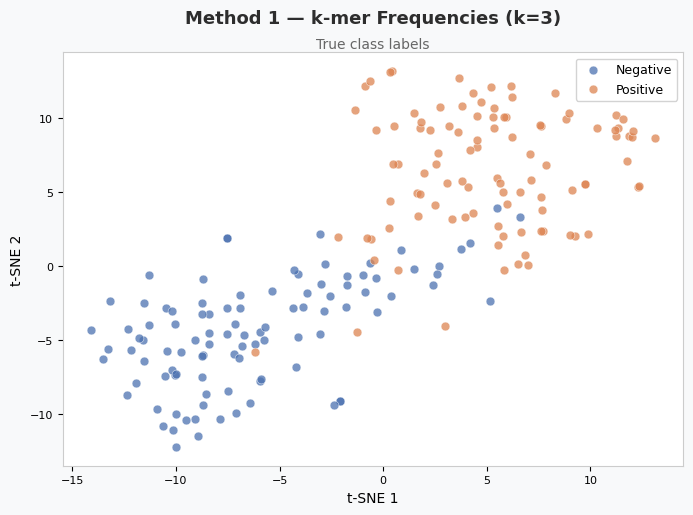

In [36]:
COLORS = {'Negative': '#4C72B0', 'Positive': '#DD8452'}
CLUSTER_COLORS = ['#2ca02c', '#d62728']

fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('#F8F9FA')

gs = gridspec.GridSpec(2, 2, hspace=0.38, wspace=0.32,
                       left=0.07, right=0.97, top=0.90, bottom=0.08)
# Row 1: true labels
ax1 = fig.add_subplot(gs[0, 0])
label_map = {'Negative': 'Negative', 'Positive': 'Positive'}
scatter(ax1, emb1, label_names, 'Method 1 — k-mer Frequencies (k=3)',
        'True class labels', label_map, COLORS)

In [63]:
parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='ESM2', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

args.model,args.alphabet = load_model(args)

Transferred model to GPU


In [41]:
esm2_emb=[]
ind=0
for seq in sequences:
    print(ind)
    ind+=1
    args.sequence = seq
    wt_output = main(args)
    emb = wt_output[1:-1].cpu().numpy()
    esm2_emb.append(np.mean(emb, axis=0))

esm2_emb=np.vstack(esm2_emb)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [42]:
scaler = StandardScaler()

esm2_emb_scaled = scaler.fit_transform(esm2_emb)
pca_esm2 = PCA(n_components=50, random_state=42)
esm2_emb_pca = pca_esm2.fit_transform(esm2_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb2 = tsne1.fit_transform(esm2_emb_pca)

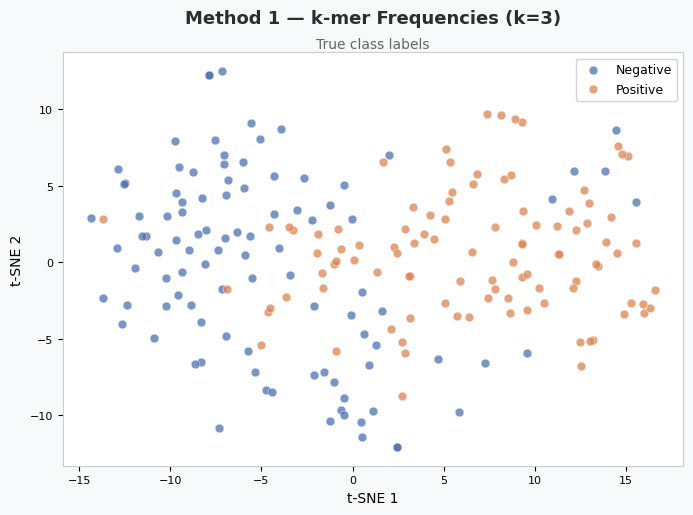

In [46]:
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('#F8F9FA')

gs = gridspec.GridSpec(2, 2, hspace=0.38, wspace=0.32,
                       left=0.07, right=0.97, top=0.90, bottom=0.08)
# Row 1: true labels
ax1 = fig.add_subplot(gs[0, 0])
label_map = {'Negative': 'Negative', 'Positive': 'Positive'}
scatter(ax1, emb2, label_names, 'Method 1 — k-mer Frequencies (k=3)',
        'True class labels', label_map, COLORS)


In [5]:
sys.path.insert(0, "C:\\Users\yjm85\\Downloads\\SeqDance-main\\SeqDance-main\\model")
# C:\Users\yjm85\Downloads\SeqDance-main\SeqDance-main\model

In [6]:
from transformers import AutoTokenizer
from model import ESMwrap
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
esm2_select = 'model_35M'
model_select = 'seqdance' # 'seqdance' or 'esmdance'
dance_model = ESMwrap(esm2_select, model_select)
# Load the SeqDance model from huggingface
dance_model = dance_model.from_pretrained("ChaoHou/ESMDance")
dance_model = dance_model.to(device)
dance_model.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESMwrap(
  (esm2): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affin

In [15]:
seqdance_emb=[]
new_label_names=[]
ind=0
for seq in sequences:
    if len(seq)>1024:
        continue
    new_label_names.append(label_names[ind])
    print(ind)
    ind+=1
    raw_input = tokenizer([seq], return_tensors="pt")
    raw_input = raw_input.to(device)
    with torch.no_grad():
        seq_emb = dance_model(raw_input, return_res_emb=True, return_attention_map=False, return_res_pred=False, return_pair_pred=False)
        seq_emb = seq_emb['res_emb'][:,1:-1,:].squeeze(0)
        emb = seq_emb.cpu().numpy()
        seqdance_emb.append(np.mean(emb, axis=0))

seqdance_emb=np.vstack(seqdance_emb)
new_label_names=np.array(new_label_names)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165


In [18]:
new_label_names

array(['Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negati

In [19]:
scaler = StandardScaler()

seqdance_emb_scaled = scaler.fit_transform(seqdance_emb)
pca_seqdance = PCA(n_components=50, random_state=42)
seqdance_emb_pca = pca_seqdance.fit_transform(seqdance_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb3 = tsne1.fit_transform(seqdance_emb_pca)

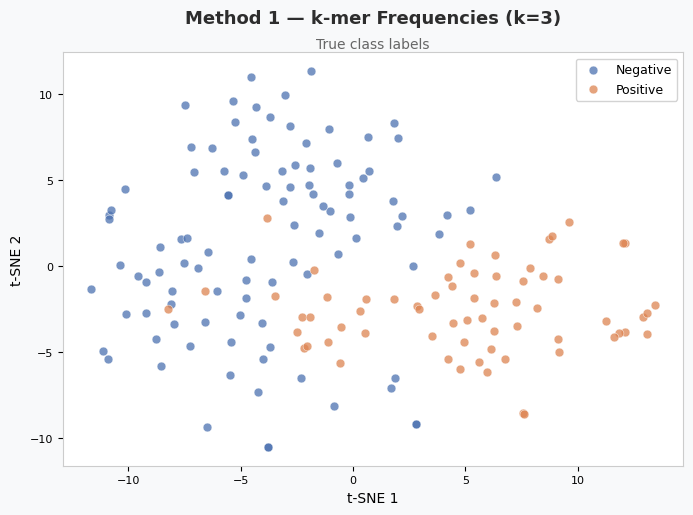

In [21]:
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('#F8F9FA')

gs = gridspec.GridSpec(2, 2, hspace=0.38, wspace=0.32,
                       left=0.07, right=0.97, top=0.90, bottom=0.08)
# Row 1: true labels
ax1 = fig.add_subplot(gs[0, 0])
label_map = {'Negative': 'Negative', 'Positive': 'Positive'}
scatter(ax1, emb3, new_label_names, 'Method 1 — k-mer Frequencies (k=3)',
        'True class labels', label_map, COLORS)

In [10]:
import gc
# del dplm_emb
# del dplm_emb_scaled
# del esm2_emb
# del esm2_emb_scaled
# del outputs
# del args.model
# del seq_emb
del seqdance_emb



gc.collect()
torch.cuda.empty_cache()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ── 1. Load & parse ───────────────────────────────────────────────────────────
df_raw = pd.read_excel('../evaluate/phase_sep/tableS2.xlsx', header=None)
df_raw = df_raw.iloc[1:].reset_index(drop=True)

records = []
for i in range(0, len(df_raw) - 1, 2):
    row_a = df_raw.iloc[i]
    row_b = df_raw.iloc[i + 1]
    records.append({
        'class':    row_a[0],
        'subclass': row_a[1],
        'id':       str(row_a[2]).strip('>'),
        'sequence': str(row_b[2])
    })
data = pd.DataFrame(records)
sequences       = data['sequence'].values
class_labels    = data['class'].values
subclass_labels = data['subclass'].values
combined_labels = [f"{c} / {s}" for c, s in zip(class_labels, subclass_labels)]

le_class = LabelEncoder()
y_class  = le_class.fit_transform(class_labels)

print("Group counts:")
print(data.groupby(['class', 'subclass']).size(), "\n")

Group counts:
class     subclass  
Negative  Disordered    100
          Folded        100
Positive  Disordered    100
          Folded        100
dtype: int64 



In [2]:
import argparse

import torch

import esm
import sys
sys.path.insert(0, "../")
import esm_adapterH

import numpy as np
import yaml
from utils.utils import load_configs
from collections import OrderedDict
from Bio.PDB import PDBParser, PPBuilder
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import pairwise_distances
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from peft import PeftModel, LoraConfig, get_peft_model


# def load_checkpoints(model,checkpoint_path):
#         if checkpoint_path is not None:
#             checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
#             if np.sum(["adapter_layer_dict" in key for key in checkpoint[
#                 'state_dict1'].keys()]) == 0:  # using old checkpoints, need to rename the adapter_layer into adapter_layer_dict.adapter_0
#                 new_ordered_dict = OrderedDict()
#                 for key, value in checkpoint['state_dict1'].items():
#                     if "adapter_layer_dict" not in key:
#                         new_key = key.replace('adapter_layer', 'adapter_layer_dict.adapter_0')
#                         new_ordered_dict[new_key] = value
#                     else:
#                         new_ordered_dict[key] = value
                
#                 model.load_state_dict(new_ordered_dict, strict=False)
#             else:
#                 #this model does not contain esm2
#                 new_ordered_dict = OrderedDict()
#                 for key, value in checkpoint['state_dict1'].items():
#                         key = key.replace("esm2.","")
#                         new_ordered_dict[key] = value
                
#                 model.load_state_dict(new_ordered_dict, strict=False)
            
#             print("checkpoints were loaded from " + checkpoint_path)
#         else:
#             print("checkpoints not exist "+ checkpoint_path)

def load_checkpoints(model,checkpoint_path):
        if checkpoint_path is not None:
            checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
            if  any('adapter' in name for name, _ in model.named_modules()):
                if np.sum(["adapter_layer_dict" in key for key in checkpoint[
                    'state_dict1'].keys()]) == 0:  # using old checkpoints, need to rename the adapter_layer into adapter_layer_dict.adapter_0
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                        if "adapter_layer_dict" not in key:
                            new_key = key.replace('adapter_layer', 'adapter_layer_dict.adapter_0')
                            new_ordered_dict[new_key] = value
                        else:
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
                else:
                    #this model does not contain esm2
                    new_ordered_dict = OrderedDict()
                    for key, value in checkpoint['state_dict1'].items():
                            key = key.replace("esm2.","")
                            new_ordered_dict[key] = value
                    
                    model.load_state_dict(new_ordered_dict, strict=False)
            elif  any('lora' in name for name, _ in model.named_modules()):
                #this model does not contain esm2
                new_ordered_dict = OrderedDict()
                for key, value in checkpoint['state_dict1'].items():
                        print(key)
                        key = key.replace("esm2.","")
                        new_ordered_dict[key] = value
                
                model.load_state_dict(new_ordered_dict, strict=False)
            
            print("checkpoints were loaded from " + checkpoint_path)
        else:
            print("checkpoints not exist "+ checkpoint_path)

# def load_model(args):
#     if args.model_type=="d-plm":
#         with open(args.config_path) as file:
#             config_file = yaml.full_load(file)
#             configs = load_configs(config_file, args=None)
        
#         # inference for each model
#         model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)
#         load_checkpoints(model,args.model_location)
#     elif args.model_type=="ESM2":
#         #if use ESM2
#         model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    
    
#     model.eval()
#     if torch.cuda.is_available():
#         model = model.cuda()
#         print("Transferred model to GPU")
    
#     return model,alphabet

def load_model(args):
    if args.model_type=="d-plm":
        with open(args.config_path) as file:
            config_file = yaml.full_load(file)
            configs = load_configs(config_file, args=None)
        if configs.model.esm_encoder.adapter_h.enable:
            model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)
        elif configs.model.esm_encoder.lora.enable:
            model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
            lora_targets =  ["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj","self_attn.out_proj"]
            target_modules=[]
            if configs.model.esm_encoder.lora.esm_num_end_lora > 0:
                start_layer_idx = np.max([model.num_layers - configs.model.esm_encoder.lora.esm_num_end_lora, 0])
                for idx in range(start_layer_idx, model.num_layers):
                    for layer_name in lora_targets:
                        target_modules.append(f"layers.{idx}.{layer_name}")
                
            peft_config = LoraConfig(
                inference_mode=False,
                r=configs.model.esm_encoder.lora.r,
                lora_alpha=configs.model.esm_encoder.lora.alpha,
                target_modules=target_modules,
                lora_dropout=configs.model.esm_encoder.lora.dropout,
                bias="none",
                # modules_to_save=modules_to_save
            )
            peft_model = get_peft_model(model, peft_config)
        
        # inference for each model
        # model, alphabet = esm_adapterH.pretrained.esm2_t33_650M_UR50D(configs.model.esm_encoder.adapter_h)/
        load_checkpoints(model,args.model_location)
    elif args.model_type=="ESM2":
        #if use ESM2
        model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    
    
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")
    
    return model,alphabet

def main(args):
    batch_converter = args.alphabet.get_batch_converter()
    
    data = [
        ("protein1", args.sequence),
    ]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    
    with torch.no_grad():
        wt_representation = args.model(batch_tokens.cuda(),repr_layers=[args.model.num_layers])["representations"][args.model.num_layers]
    
    wt_representation = wt_representation.squeeze(0) #only one sequence a time
    return wt_representation

In [3]:
parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='../results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='../results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='d-plm', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

args.model,args.alphabet = load_model(args)

dplm_emb=[]
ind=0
for seq in sequences:
    print(ind)
    ind+=1
    args.sequence = seq
    wt_output = main(args)
    emb = wt_output[1:-1].cpu().numpy()
    dplm_emb.append(np.mean(emb, axis=0))

dplm_emb=np.vstack(dplm_emb)

checkpoints were loaded from ../results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth
Transferred model to GPU
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


In [4]:
scaler = StandardScaler()

dplm_emb_scaled = scaler.fit_transform(dplm_emb)
pca_dplm = PCA(n_components=50, random_state=42)
dplm_emb_pca = pca_dplm.fit_transform(dplm_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb1 = tsne1.fit_transform(dplm_emb_pca)

In [5]:
COMBINED_PALETTE = {
    'Negative / Disordered': '#4C72B0',
    'Negative / Folded':     '#55A868',
    'Positive / Disordered': '#DD8452',
    'Positive / Folded':     '#C44E52',
}
CLUSTER_PALETTE = {
    'Cluster 0': '#8172B2',
    'Cluster 1': '#64B5CD',
}

def legend_handles(palette):
    return [Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
                   markersize=9, label=lbl) for lbl, c in palette.items()]

def scatter_panel(ax, emb, color_vals, palette, title, subtitle):
    unique = list(dict.fromkeys(color_vals))
    for val in unique:
        mask = np.array(color_vals) == val
        ax.scatter(emb[mask, 0], emb[mask, 1],
                   color=palette[val], alpha=0.75, s=30,
                   edgecolors='white', linewidths=0.4)
    ax.set_title(title, fontsize=12, fontweight='bold', color='#2d2d2d', pad=16)
    ax.text(0.5, 1.025, subtitle, transform=ax.transAxes, ha='center',
            fontsize=9.5, color='#555555')
    ax.set_xlabel('t-SNE 1', fontsize=9)
    ax.set_ylabel('t-SNE 2', fontsize=9)
    ax.legend(handles=legend_handles({v: palette[v] for v in unique}),
              fontsize=8.5, framealpha=0.88, loc='best')
    ax.set_facecolor('#FFFFFF')
    for sp in ax.spines.values():
        sp.set_edgecolor('#CCCCCC')
    ax.tick_params(labelsize=8)

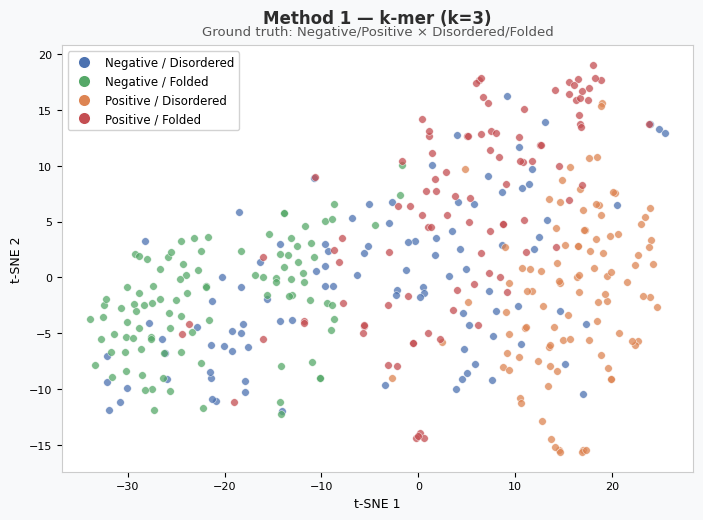

In [7]:
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('#F8F9FA')
gs = gridspec.GridSpec(2, 2, hspace=0.42, wspace=0.28,
                       left=0.07, right=0.97, top=0.92, bottom=0.06)

# Row 0 — ground truth with 4 combined colours
scatter_panel(fig.add_subplot(gs[0, 0]), emb1, combined_labels, COMBINED_PALETTE,
              'Method 1 — k-mer (k=3)',
              'Ground truth: Negative/Positive × Disordered/Folded')

In [8]:
parser = argparse.ArgumentParser(description='PyTorch SimCLR')
parser.add_argument("--model-location", type=str, help="xx", default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/vivit_3/checkpoints/checkpoint_best_val_rmsf_cor.pth')
parser.add_argument("--config-path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/vivit_3/config_vivit3.yaml', help="xx")
parser.add_argument("--model-type", default='ESM2', type=str, help="xx")
parser.add_argument("--sequence", type=str, help="xx")
parser.add_argument("--output_path", type=str, default='/cluster/pixstor/xudong-lab/yuexu/D_PLM/evaluate/', help="xx")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

args.model,args.alphabet = load_model(args)

esm2_emb=[]
ind=0
for seq in sequences:
    print(ind)
    ind+=1
    args.sequence = seq
    wt_output = main(args)
    emb = wt_output[1:-1].cpu().numpy()
    esm2_emb.append(np.mean(emb, axis=0))

esm2_emb=np.vstack(esm2_emb)

Transferred model to GPU
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
2

In [9]:
scaler = StandardScaler()

esm2_emb_scaled = scaler.fit_transform(esm2_emb)
pca_esm2 = PCA(n_components=50, random_state=42)
esm2_emb_pca = pca_esm2.fit_transform(esm2_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb2 = tsne1.fit_transform(esm2_emb_pca)

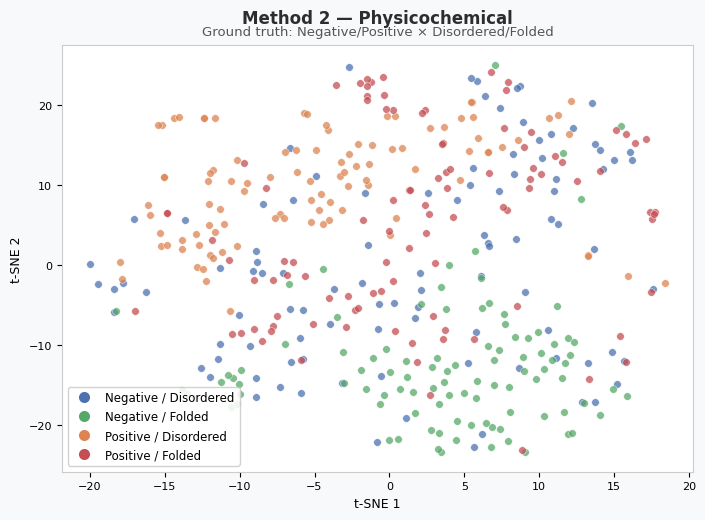

In [10]:
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('#F8F9FA')
gs = gridspec.GridSpec(2, 2, hspace=0.42, wspace=0.28,
                       left=0.07, right=0.97, top=0.92, bottom=0.06)

# Row 0 — ground truth with 4 combined colours

scatter_panel(fig.add_subplot(gs[0, 1]), emb2, combined_labels, COMBINED_PALETTE,
              'Method 2 — Physicochemical',
              'Ground truth: Negative/Positive × Disordered/Folded')

In [13]:
km1      = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster1 = km1.fit_predict(dplm_emb_scaled)
ari1     = adjusted_rand_score(y_class, cluster1)

km2      = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster2 = km2.fit_predict(esm2_emb_scaled)
ari2     = adjusted_rand_score(y_class, cluster2)

print(f"ARI — Method 1 (k-mer, k=2 vs Neg/Pos):          {ari1:.4f}")
print(f"ARI — Method 2 (Physicochemical, k=2 vs Neg/Pos): {ari2:.4f}")

ARI — Method 1 (k-mer, k=2 vs Neg/Pos):          0.4147
ARI — Method 2 (Physicochemical, k=2 vs Neg/Pos): 0.0507


In [15]:
from transformers import AutoTokenizer
if not "C:\\Users\yjm85\\Downloads\\SeqDance-main\\SeqDance-main\\model" in sys.path:
  sys.path.insert(0, "C:\\Users\yjm85\\Downloads\\SeqDance-main\\SeqDance-main\\model")
from model import ESMwrap

In [18]:
len(combined_labels)

400

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
esm2_select = 'model_35M'
model_select = 'seqdance' # 'seqdance' or 'esmdance'
dance_model = ESMwrap(esm2_select, model_select)
# Load the SeqDance model from huggingface
dance_model = dance_model.from_pretrained("ChaoHou/ESMDance")
dance_model = dance_model.to(device)
dance_model.eval()

seqdance_emb=[]
new_label_names=[]
new_y_class=[]
ind=0
for seq in sequences:
    if len(seq)>1024:
        continue
    new_label_names.append(combined_labels[ind])
    new_y_class.append(y_class[ind])
    print(ind)
    ind+=1
    raw_input = tokenizer([seq], return_tensors="pt")
    raw_input = raw_input.to(device)
    with torch.no_grad():
        seq_emb = dance_model(raw_input, return_res_emb=True, return_attention_map=False, return_res_pred=False, return_pair_pred=False)
        seq_emb = seq_emb['res_emb'][:,1:-1,:].squeeze(0)
        emb = seq_emb.cpu().numpy()
        seqdance_emb.append(np.mean(emb, axis=0))

seqdance_emb=np.vstack(seqdance_emb)
new_label_names=np.array(new_label_names)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
scaler = StandardScaler()

seqdance_emb_scaled = scaler.fit_transform(seqdance_emb)
pca_seqdance = PCA(n_components=50, random_state=42)
seqdance_emb_pca = pca_seqdance.fit_transform(seqdance_emb_scaled)
tsne1 = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
emb3 = tsne1.fit_transform(seqdance_emb_pca)



km3      = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster3 = km3.fit_predict(seqdance_emb_scaled)
ari3     = adjusted_rand_score(new_y_class, cluster3)

print(f"ARI — Method 1 (k-mer, k=2 vs Neg/Pos):          {ari3:.4f}")


ARI — Method 1 (k-mer, k=2 vs Neg/Pos):          0.2440


In [24]:
seqdance_emb.shape

(400, 1280)

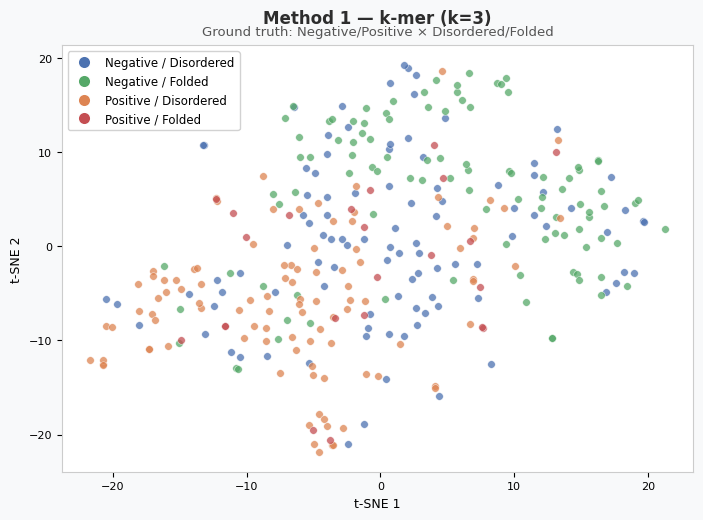

In [27]:
fig = plt.figure(figsize=(16, 12))
fig.patch.set_facecolor('#F8F9FA')
gs = gridspec.GridSpec(2, 2, hspace=0.42, wspace=0.28,
                       left=0.07, right=0.97, top=0.92, bottom=0.06)

# Row 0 — ground truth with 4 combined colours
scatter_panel(fig.add_subplot(gs[0, 0]), emb3, new_label_names, COMBINED_PALETTE,
              'Method 1 — k-mer (k=3)',
              'Ground truth: Negative/Positive × Disordered/Folded')